In [2]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import constants as const
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import evidential_deep_learning as edl
print(tf.__version__)

#import sciann as sn
#from scipy import stats
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import random
import statistics


2.8.1


In [3]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Dataset/Dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (727292, 6)


,turbine,V,theta,W,T,P
727287,R80736,20.48,0.293564,1.801180,10817.3,2041980.0
727288,R80736,20.50,0.307352,1.799085,10837.3,2043120.0
727289,R80721,20.78,0.323933,1.799085,10850.1,2045870.0
727290,R80711,20.94,0.341386,1.799085,10853.8,2046570.0
727291,R80736,21.67,0.347670,1.798038,10871.8,2048260.0


In [4]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine    0
V          0
theta      0
W          0
T          0
P          0
dtype: int64


In [5]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,V,theta,W,T,P
727287,20.48,0.293564,1.801180,10817.3,2041980.0
727288,20.50,0.307352,1.799085,10837.3,2043120.0
727289,20.78,0.323933,1.799085,10850.1,2045870.0
727290,20.94,0.341386,1.799085,10853.8,2046570.0
727291,21.67,0.347670,1.798038,10871.8,2048260.0


In [6]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

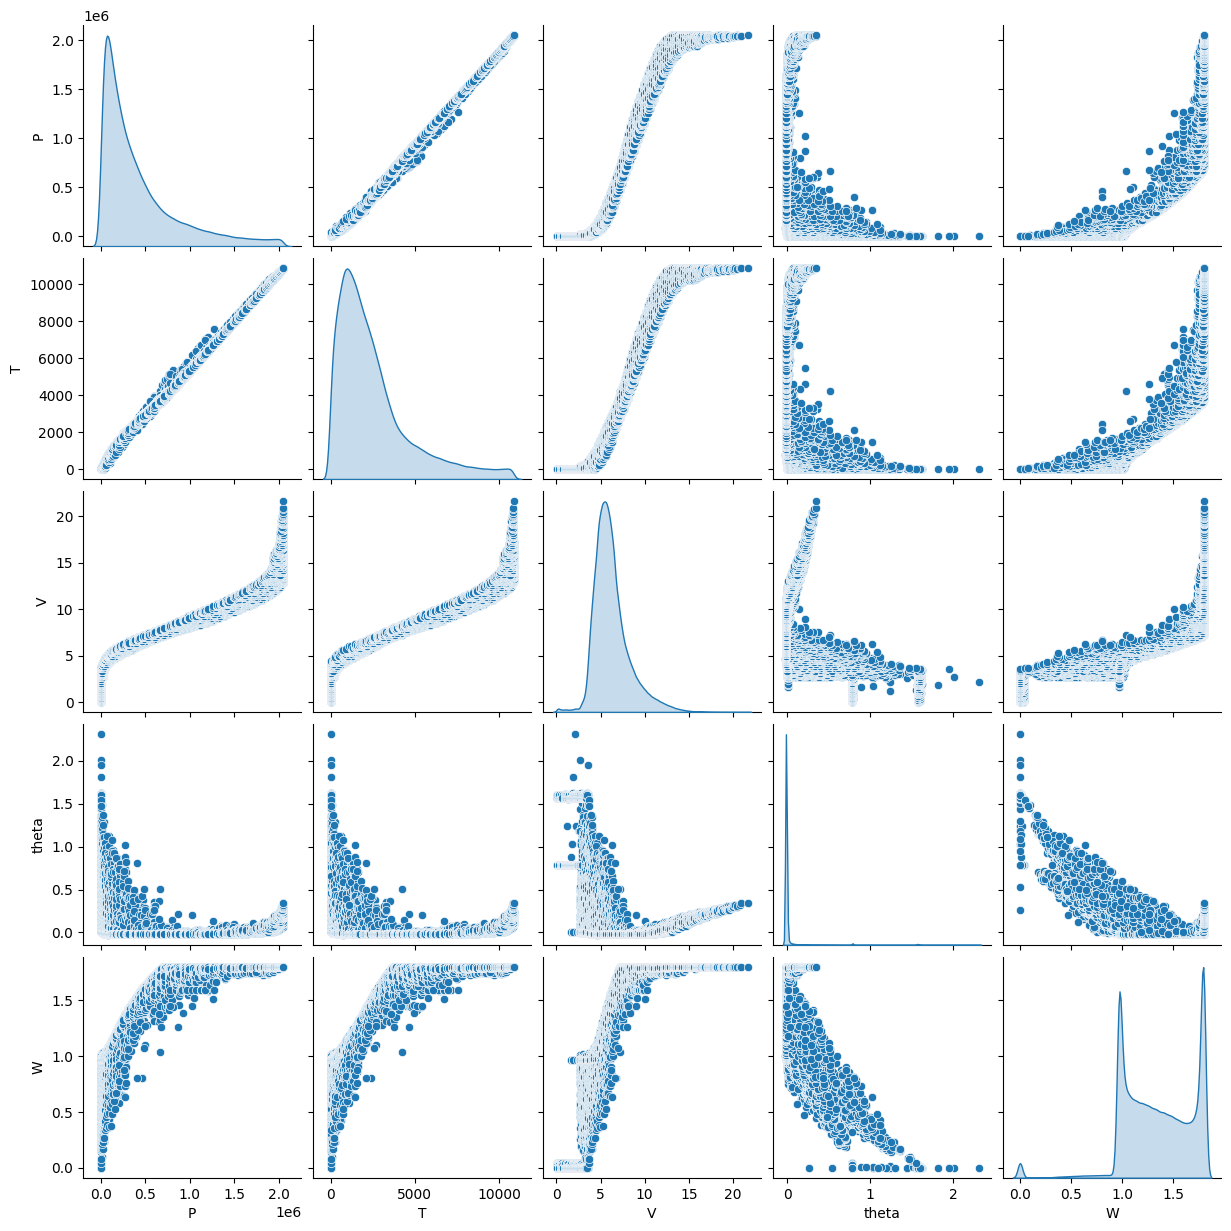

In [6]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'T', 'V', 'theta', 'W']], diag_kind='kde')


In [7]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
V,727292.0,6.281493,1.995660,0.230000,4.960000,5.870000,7.090000,2.167000e+01
theta,727292.0,0.002826,0.129452,-0.026704,-0.017453,-0.017279,-0.015708,2.312212e+00
W,727292.0,1.356542,0.329573,0.000000,1.089085,1.346696,1.660855,1.803274e+00
T,727292.0,2619.547843,2241.645819,0.000000,1043.010000,1963.324950,3376.169900,1.087570e+04
P,727292.0,439958.330594,442728.758322,0.000000,121400.000000,281620.000000,596549.992500,2.051870e+06


In [8]:
# Normalization

print(dataset.describe().transpose()[['mean', 'std']])

#tf.enable_eager_execution()
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(np.array(train_features))

# adapt() method does not work, so we standarize each feature by hand

""" V = np.array(train_features['V'])
theta = np.array(train_features['theta'])
W = np.array(train_features['W'])
#Torque = np.array(train_labels['T'])
#Power = np.array(train_labels['P'])
Power = np.array(train_labels)

V_avrg = np.average(V[:])
V_std = np.std(V[:])
theta_avrg = np.average(theta[:])
theta_std = np.std(theta[:])
W_avrg = np.average(W[:])
W_std = np.std(W[:])
#T_avrg = np.average(Torque[:])
#T_std = np.std(Torque[:])
P_avrg = np.average(Power[:])
P_std = np.std(Power[:])

V[:] = ( V[:] - V_avrg ) / V_std
theta[:] = ( theta[:] - theta_avrg ) / theta_std
W[:] = ( W[:] - W_avrg ) / W_std
#Torque[:] = ( Torque[:] - T_avrg ) / T_std
Power[:] = ( Power[:] - P_avrg ) / P_std
 """

# Normalize pandas dataframe
#train_features=(train_features-train_features.mean())/train_features.std()
#test_features=(test_features-test_features.mean())/test_features.std()
#train_labels=(train_labels-train_labels.mean())/train_labels.std()
#test_features=(test_labels-test_labels.mean())/test_labels.std()

train_dataset_norm=(train_dataset-dataset.mean())/dataset.std()
test_dataset_norm=(test_dataset-dataset.mean())/dataset.std()

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                mean            std
V           6.281493       1.995660
theta       0.002826       0.129452
W           1.356542       0.329573
T        2619.547843    2241.645819
P      439958.330594  442728.758322

Normalized dataset
           mean       std
V     -0.000640  0.999263
theta  0.000388  1.002013
W     -0.000354  1.000316
T     -0.000550  0.999261
P     -0.000558  0.999263


In [9]:
# Split features from labels/targets

train_features = train_dataset_norm.copy()
test_features = test_dataset_norm.copy()

train_labels = train_features.pop('P')
test_labels = test_features.pop('P')

print(train_features.shape)
print(train_labels.shape)

(581834, 4)
(581834,)


In [9]:
# 1-input linear model 

""" x = np.array(train_features['V'])
inputs = tf.keras.Input(shape=(1,))

model = tf.keras.Sequential([
    inputs,
    layers.Dense(units=1)
])

model.summary() """


" x = np.array(train_features['V'])\ninputs = tf.keras.Input(shape=(1,))\n\nmodel = tf.keras.Sequential([\n    inputs,\n    layers.Dense(units=1)\n])\n\nmodel.summary() "

In [10]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  input = tf.keras.Input(shape=(3,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [11]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Power')


2023-07-24 11:23:54.544765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-24 11:23:54.596669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-07-24 11:23:54.596686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-07-24 11:23:54.597587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [11]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

x = train_features[['V','theta','W']]
# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=128, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 2
n_units: 64
learning_rate: 0.001
activation_function: relu



In [12]:
# Define single model

n_layers = 2
n_units = 64
learning_rate = 0.001
activation_function = 'relu'

input = tf.keras.Input(shape=(3,))
model = keras.Sequential()
model.add(input)

for i in range(n_layers):    
    model.add(keras.layers.Dense(units=n_units, activation=activation_function))
#model.add(keras.layers.Dense(1))
model.add(edl.layers.DenseNormalGamma(1))

model.summary() 

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
#              loss='mean_absolute_error') 

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=EvidentialRegressionLoss)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_normal_gamma (DenseNo  (None, 4)                260       
 rmalGamma)                                                      
                                                                 
Total params: 4,676
Trainable params: 4,676
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-8)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
#model = tuner.hypermodel.build(best_hps)
x = train_features[['V','theta','W']]
#history = model.fit(x, train_labels, epochs=150, batch_size=128, validation_split=0.2, callbacks=[reduce_lr])
history = model.fit(x, train_labels, epochs=200, batch_size=128, validation_split=0.2, callbacks=[reduce_lr])

Epoch 1/200
3637/3637 [==============================] - 3s 734us/step - loss: -1.9458 - val_loss: -2.0543 - lr: 0.0010
Epoch 2/200
3637/3637 [==============================] - 3s 724us/step - loss: -2.0970 - val_loss: -2.1517 - lr: 0.0010
Epoch 3/200
3637/3637 [==============================] - 3s 723us/step - loss: -2.1094 - val_loss: -2.0885 - lr: 0.0010
Epoch 4/200
3637/3637 [==============================] - 3s 729us/step - loss: -2.1191 - val_loss: -2.1219 - lr: 0.0010
Epoch 5/200
3637/3637 [==============================] - 3s 724us/step - loss: -2.1314 - val_loss: -2.1711 - lr: 0.0010
Epoch 6/200
3637/3637 [==============================] - 3s 717us/step - loss: -2.1347 - val_loss: -2.1807 - lr: 0.0010
Epoch 7/200
3637/3637 [==============================] - 3s 733us/step - loss: -2.1386 - val_loss: -2.1895 - lr: 0.0010
Epoch 8/200
3637/3637 [==============================] - 3s 717us/step - loss: -2.1458 - val_loss: -2.1651 - lr: 0.0010
Epoch 9/200
3637/3637 [=================

Best epoch: 198


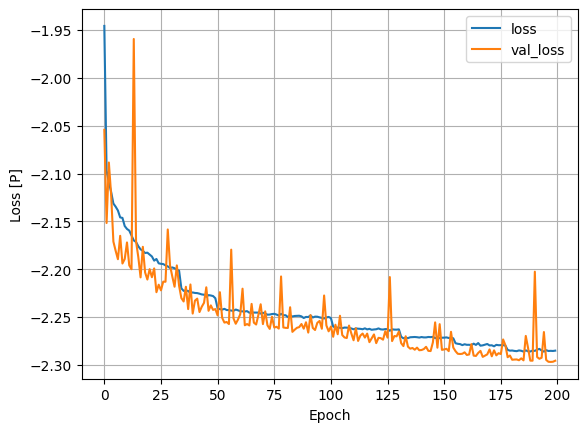

In [15]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [P]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x, train_labels, epochs=best_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr]) """

In [16]:
# save model weights 
#model.save_weights('../Models/Torque_model_weights.hdf5')

# load model weights
#model.load_weights('../Models/Torque_model_weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('../Models/Power_evidential_model.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

In [ ]:
# load model 

#model = tf.keras.models.load_model('../Models/Power_evidential_model.h5')
#model.summary()

# load model weights
#model.load_weights('../Models/Torque_model_weights.hdf5')

In [18]:
def plot_PredvsTrue(y_true, y_pred, n_stds=2):

    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.8*p1, 1.1*p2)
    #plt.gca().set_ylim(0.9*p1, 1.1*p2)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2023-07-24 11:35:37.138865: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37237248 exceeds 10% of free system memory.
2023-07-24 11:35:37.143150: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37237248 exceeds 10% of free system memory.
2023-07-24 11:35:37.150792: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37237248 exceeds 10% of free system memory.
2023-07-24 11:35:37.158247: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37237248 exceeds 10% of free system memory.
2023-07-24 11:35:37.165222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 37237248 exceeds 10% of free system memory.


(145458, 3)
(145458, 4)
(145458,)


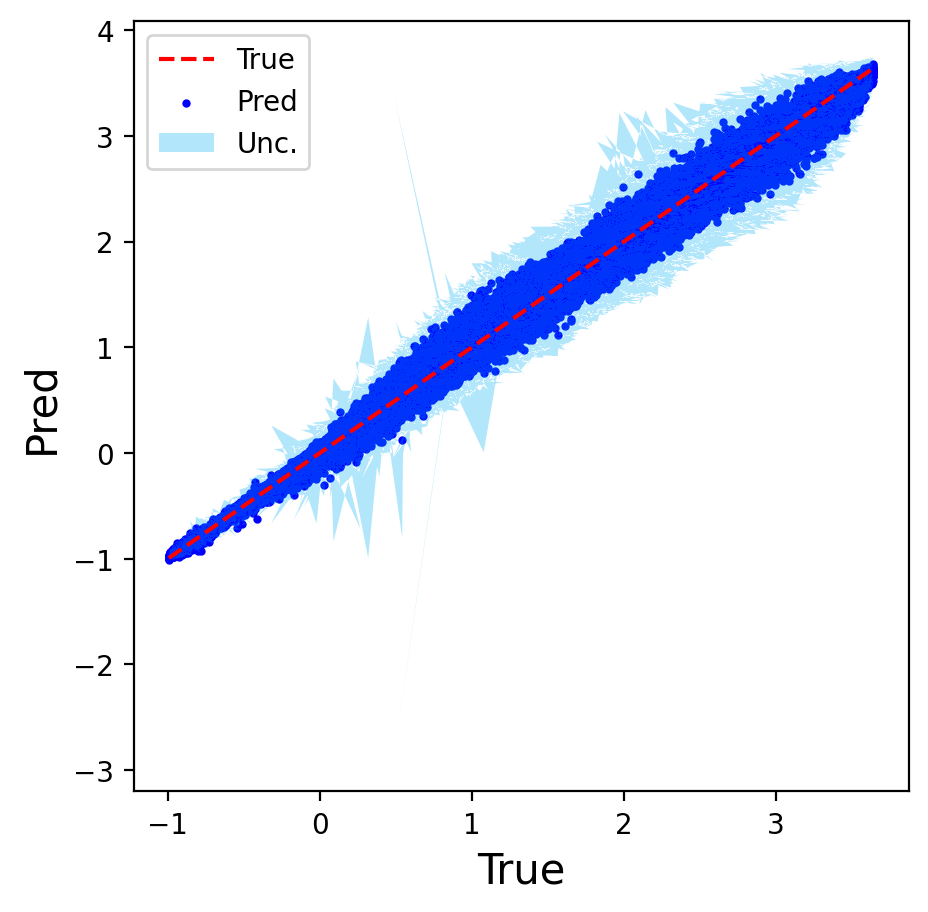

Test MAE: 0.034426626051348705


In [19]:
# Evaluation of the model on Power data

x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

print(x_test.shape)
print(y_pred.shape)
print(y_true.shape)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred[:,0])
print("Test MAE: "+str(test_mae))

In [71]:
def plot_PredvsTrue_error(y_true, y_pred, error, n_stds=3):

    #mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    #mu = mu[:, 0]
    #var = np.sqrt(beta / (v * (alpha - 1)))
    #var = np.minimum(var, 1e3)[:, 0]  # for visualization
    #y_true = y_true[:,0]
    mu = y_pred
    var = error

    plt.figure(figsize=(5, 5), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="True")
    #plt.plot(y_true, y_true, 'r--', zorder=2, label="True")
    #plt.plot(y_true, mu, color='#007cab', zorder=3, label="Pred")
    plt.scatter(y_true,mu,color="blue",label="Pred",s=4)
    for k in np.linspace(0, n_stds, n_stds):
        plt.fill_between(
            y_true, (mu - k * var), (mu + k * var),
            alpha=0.75,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=5,
            zorder=1,
            label="Uncertainty" if k == 0 else None)
    #plt.gca().set_xlim(-200, 200)
    #plt.gca().set_ylim(-200, 200)
    #plt.gca().set_xlim(0.7*p1, 1.1*p2)
    #plt.gca().set_ylim(0.7*p1, 1.1*p2)
    plt.gca().set_xlim(-100000, 1.1*p2)
    plt.gca().set_ylim(-100000, 1.1*p2)
    plt.xlabel('True',fontsize=16)
    plt.ylabel('Pred',fontsize=16)
    plt.legend(loc="upper left",fontsize=14)
    plt.title('Power regression',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

['V' 'theta' 'W' 'T' 'P']
(145458,)
(145458,)
(145458,)


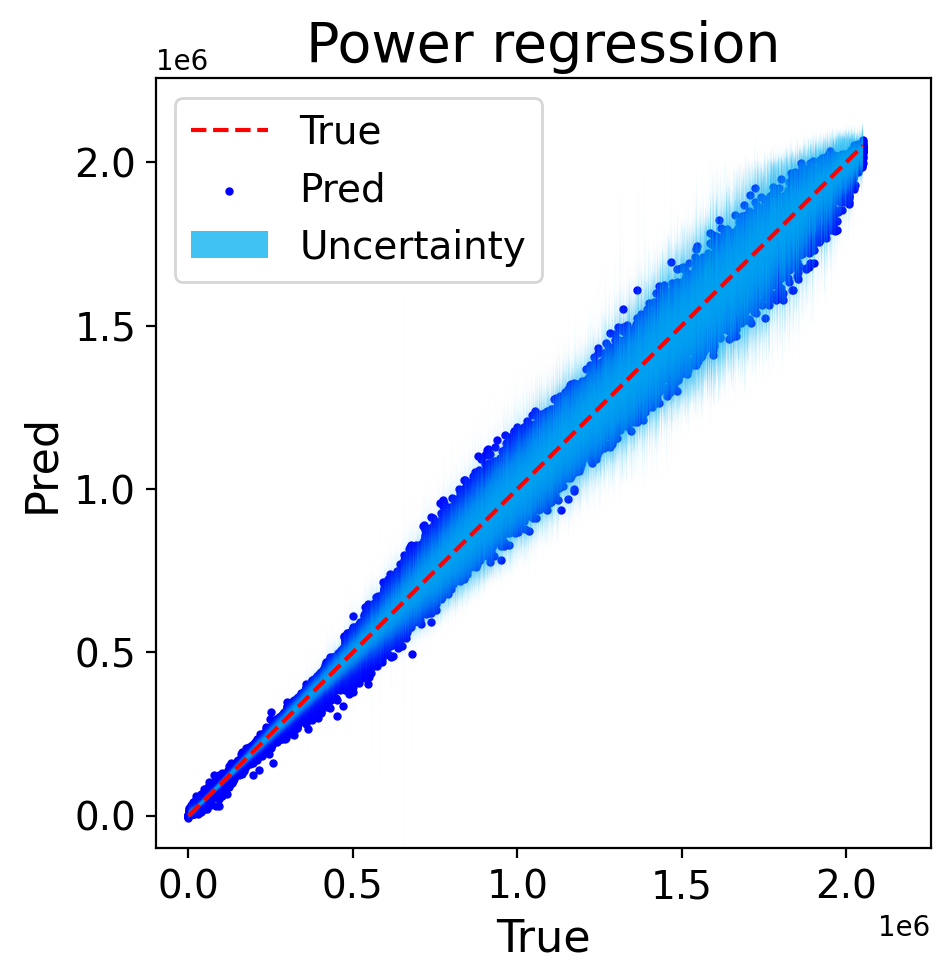


Test MAE: 15241.646984911376
Test RMSE: 27606.02994908352
Test MAPE: 3.607608646570567 %
Test R2: 0.9961346817473484


In [72]:
# Evaluate P on original units

# Plot 
x_test = np.array(test_features[['V','theta','W']])
y_pred = model(x_test)
y_true = np.array(test_labels)

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )
column_name = dataset.columns.values
print(column_name)
P_column = 4 

mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
var = np.sqrt(beta / (v * (alpha - 1)))
y_pred = mu * x_std[P_column] + x_mean[P_column]
y_true = y_true * x_std[P_column] + x_mean[P_column]
error = var * x_std[P_column]

y_pred = y_pred[:,0]
y_pred = y_pred.numpy()
error = error[:,0]
print(y_pred.shape)
print(y_true.shape)
print(error.shape)

index_sorted = np.argsort(y_true)
y_true = y_true[index_sorted]
y_pred = y_pred[index_sorted]
error = error[index_sorted]

plot_PredvsTrue_error(y_true, y_pred, error)

p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

# Metrics
test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

['V' 'theta' 'W' 'T' 'P']
[ 0.25  0.25  0.45  0.77  0.9   1.13  1.41  1.71  1.83  2.12  2.34  2.68
  2.76  3.06  3.15  3.44  3.6   3.83  4.24  4.39  4.53  4.76  4.95  5.25
  5.59  5.65  5.85  6.12  6.5   6.7   6.78  7.06  7.3   7.61  7.84  8.03
  8.24  8.45  8.59  8.78  9.13  9.3   9.49  9.85  9.94 10.14 10.5  10.68
 10.83 11.24 11.28 11.51 11.72 12.1  12.29 12.42 12.78 12.88 13.11 13.42
 13.69 13.9  14.17 14.29 14.47 14.81 14.9  15.16 15.39 15.68 15.85 16.03
 16.37 16.53 16.83 17.06 17.25 17.43 17.66 17.79]
(80, 4)
[   0.006    0.006    0.007    0.005    0.005    0.005    0.005    0.005
    0.006    0.005    0.006    0.004    0.008    0.003    0.003   -0.812
    3.495   25.823   51.067   59.93    76.711  120.526  103.662  141.268
  195.714  263.314  314.523  266.164  403.736  458.946  519.967  554.602
  616.345  764.53   810.605  846.17   904.589 1001.925 1063.745 1048.254
 1193.221 1238.543 1164.59  1335.376 1388.937 1455.802 1503.151 1553.576
 1539.371 1681.369 1662.757 1690.566 173

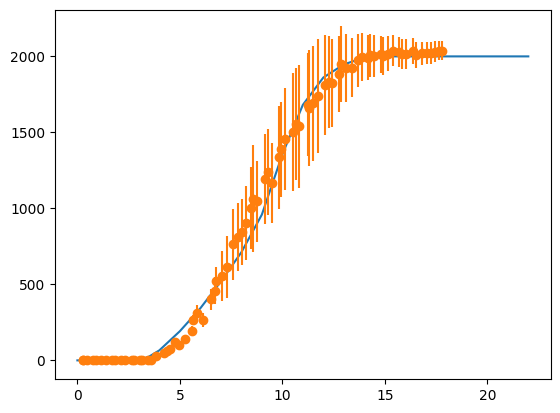

In [26]:
# Power curve: P vs Velocity

# Evaluate power and convert to original units
x_test = np.array(test_features[['V','theta','W']])
P_pred = np.array(model(x_test))
P_true = np.array(test_labels)

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )
column_name = dataset.columns.values
print(column_name)
P_column = 4 

#print(x_test.shape)
V_true = x_test[:,0]*x_std[0] + x_mean[0]

mu, v, alpha, beta = tf.split(P_pred, 4, axis=-1)
var = np.sqrt(beta / (v * (alpha - 1)))
P_pred = mu * x_std[P_column] + x_mean[P_column]
P_true = P_true * x_std[P_column] + x_mean[P_column]
error = var * x_std[P_column]

# Power curve from manufacturer
V_manu = np.arange(0,22.5,0.5)
P_manu = [0,0,0,0,0,0,0,25,66,129,192,267,343,431,519,615,711,835,959,1157,1355,1518,1681,1771,1861,
1904,1947,1970,1987,1996,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,
2000, 2000, 2000]
P_manu = np.array(P_manu)

""" # reduce sample of test data
indexes = [i for i in range(P_pred.shape[0])]
indexes = random.sample(indexes,k=int(20000))

P_array = np.zeros(len(indexes))
V_array = np.zeros(len(indexes))
error_array = np.zeros(len(indexes))
for i in range(len(indexes)):
    P_array[i] = P_pred[indexes[i]]
    V_array[i] = V_true[indexes[i]]
    error_array[i] = error[indexes[i]] """

# Define V and P arrays with one data on each interval
x_data = np.array(test_features[['V','theta','W']])
y_data = np.array(test_labels)

vmin = 0
vmax = 18
nbins = 80
dv = (vmax-vmin)/nbins
P_array = np.zeros(nbins)
V_array = np.zeros(nbins)
error_array = np.zeros(nbins)
x_input = np.zeros((nbins,3))
#x_input = np.zeros((1,3))

for i in range(nbins):
    vl = vmin + i*dv
    vr = vl + dv
    #V_array[i] = (vl+vr)/2.0
    for j in range(x_data.shape[0]):
        velocity = x_data[j,0]*x_std[0] + x_mean[0]
        if( vl<velocity and velocity<vmax ):
            V_array[i] = velocity
            x_input[i,:] = x_data[j,:]
            #x_input[0,:] = x_data[j,:]
            P_pred = np.array(model(x_input))
            break

print(V_array)
P_pred = np.array(model(x_input))
print(P_pred.shape)
mu, v, alpha, beta = tf.split(P_pred, 4, axis=-1)
var = np.sqrt(beta / (v * (alpha - 1)))
P_array[:] = mu[:,0] * x_std[4] + x_mean[4]
error_array[:] = 5*var[:,0] * x_std[4]    # 3 sigma
print(P_array/1000)
#print(P_array.shape)
#print(error_array.shape)


# Plot
#plt.plot(V_true,P_pred/1000)
plt.plot(V_manu,P_manu)
#plt.plot(V_array,P_array/1000)
plt.errorbar(V_array, P_array/1000, yerr=error_array/1000,fmt="o")
plt.show()

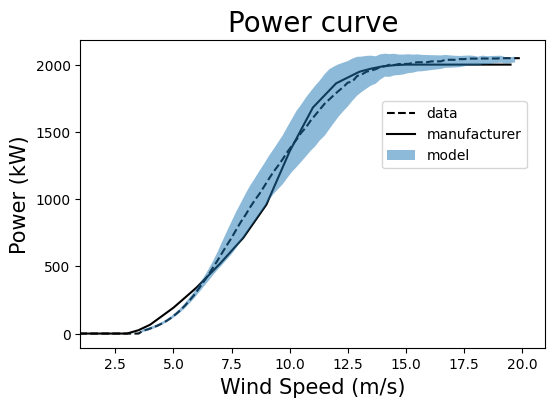

[37.03604, 39.07609, 39.973625, 43.08384, 43.7978, 43.42021, 46.655807, 49.839428, 54.64859, 48.59577, 46.416603, 45.611343, 50.301502, 65.080536, 297.97583, 268.49176, 465.7932, 3210.1582, 3402.0417, 3398.1765, 3359.941, 3316.7566, 3461.6072, 3823.153, 4413.1484, 5165.2964, 6238.4414, 7346.731, 8400.338, 9797.002, 11503.379, 14169.938, 17338.443, 22215.514, 28715.426, 34864.54, 40537.266, 45001.957, 47600.414, 51096.086, 52248.406, 53101.258, 54131.293, 54985.848, 55053.746, 55525.395, 57998.316, 60678.965, 63207.37, 65729.43, 69713.234, 70982.055, 72972.266, 73610.305, 75207.49, 74258.734, 76356.17, 74479.41, 69970.21, 65060.77, 60395.55, 56341.99, 52285.84, 48129.414, 43917.797, 40695.367, 37040.45, 34035.203, 31340.84, 28365.533, 28185.32, 26810.51, 25391.951, 24621.3, 23350.014, 22355.664, 21196.533, 20207.586, 19427.01, 18493.463, 17636.344, 16828.516, 16005.306, 15324.62, 14539.684, 13970.5, 13127.516, 12505.758, 11783.053, 11046.14, 10681.413, 9871.182, 9493.229, 8540.988, 7676

In [23]:
# Estimated power curve with error

#dataset_norm = (dataset - dataset.mean())/dataset.std()

X_data = test_dataset[['V','theta','W']]
Y_data = test_dataset[['P']]
X_data = X_data.to_numpy(dtype='float64')
Y_data = Y_data.to_numpy(dtype='float64')

X_data_norm = test_dataset_norm[['V','theta','W']]
X_data_norm = X_data_norm.to_numpy(dtype='float64')


# Estimate the power curve with an iterative median estimation technique. 
nbins = 100
P_estimated = np.zeros(nbins)
V_estimated = np.zeros(nbins)
vmin = 0
vmax = 20
dv = (vmax-vmin)/nbins
P_estimated[0]=0.0
P_list = []
V_list = []
error_list = []
for i in range(1,nbins):
    vl = vmin + i*dv
    vr = vl + dv
    # Median of P in the bin i
    V_estimated[i] = (vl+vr)/2.0
    v_subset = (vl<X_data[:,0]) & (X_data[:,0]<vr)  # subset of v points of the bin
    #Pi = Y_data[:,1][(vl<X_data[:,0]) & (X_data[:,0]<vr)]
    Pi = Y_data[:][v_subset]                      # Power distribution of bin i
    if (len(Pi)>0):
        P_estimated[i]=statistics.median(Pi)        
        #P_estimated[i]=Pi.mean()        
    else:
        P_estimated[i]=P_estimated[i-1]

    if(V_estimated[i]>=15 and P_estimated[i]-P_estimated[i-1]<0):
        P_estimated[i] = P_estimated[i-1]

    # Predicted power with error
    Xi = X_data_norm[:][v_subset]
    Poweri = model(Xi)
    mu, v, alpha, beta = tf.split(Poweri, 4, axis=-1)
    var = np.sqrt(beta / (v * (alpha - 1)))
    mu = mu * x_std[4] + x_mean[4]    
    error = var * x_std[4]
    #print(mu.shape)
    #print(var.shape)
    if(mu.shape[0]>0):
        P_list.append(np.mean(mu[:,0]))
        V_list.append(V_estimated[i])
        error_list.append(np.mean(error[:,0]))

P_array = np.array(P_list)
V_array = np.array(V_list)
error_array = np.array(error_list)

# Power curve from manufacturer
V_manu = np.arange(0,22.5,0.5)
P_manu = [0,0,0,0,0,0,0,25,66,129,192,267,343,431,519,615,711,835,959,1157,1355,1518,1681,1771,1861,
1904,1947,1970,1987,1996,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,
2000, 2000, 2000]
P_manu = np.array(P_manu)
P_manu = P_manu[ V_manu<vmax ]
V_manu = V_manu[ V_manu<vmax ]

# Plot P vs V
plt.figure(figsize=(6,4))
plt.xlabel('Wind Speed (m/s)',fontsize=15)
plt.ylabel('Power (kW)',fontsize=15)
plt.title('Power curve',fontsize=20)
plt.plot(V_estimated, P_estimated/1000, 'k--',label='data')
plt.plot(V_manu,P_manu,'k-',label='manufacturer')
#plt.plot(V_array,P_array/1000,'b-',label='model')
#plt.errorbar(V_array, P_array/1000, yerr=3*error_array/1000,fmt="o",zorder=0,alpha=0.5)
plt.fill_between(V_array, (P_array-3*error_array)/1000, (P_array+3*error_array)/1000, zorder=2,alpha=0.5,label='model')
plt.xlim([1,21])
l1 = plt.legend(bbox_to_anchor=(0.96, 0.8), borderaxespad=0)
plt.show()

print(error_list)

Mean Absolute Error: 15241.646984911376
Mean Absolute Uncertainty: 18603.145


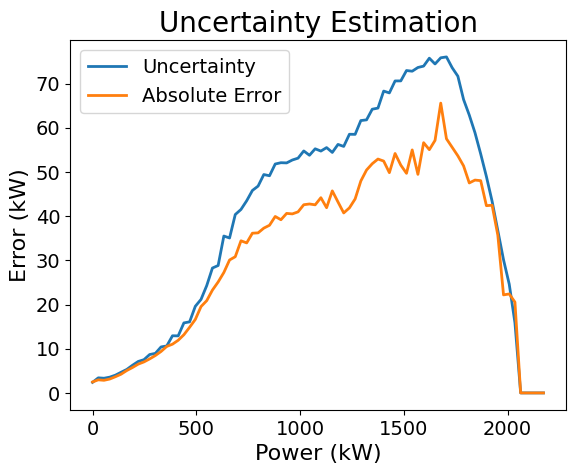

In [27]:
# Mean uncertainty. True error vs Power. Uncertainty vs Power

#print(y_pred.shape)
#print(y_true.shape)
P_pred = y_pred
P_true = y_true
error_true = np.abs(P_pred-P_true)
error_pred = error
print('Mean Absolute Error: '+str(np.mean(error_true)))
print('Mean Absolute Uncertainty: '+str(np.mean(error_pred)))

nbins = 80
Pmax = 2200*1e3
Pmin = 0
dP = (Pmax-Pmin)/nbins
error_histo = np.zeros(nbins)
uncertainty_histo = np.zeros(nbins)
n_histo = np.zeros(nbins)
for i in range(len(P_pred)):
    #j = int(P_pred[i]/dP)
    j = int(P_true[i]/dP)
    error_histo[j] = error_histo[j] + error_true[i]
    uncertainty_histo[j] = uncertainty_histo[j] + error_pred[i]
    n_histo[j] = n_histo[j]+1

for j in range(nbins):
    if(n_histo[j]>0):
        error_histo[j] = error_histo[j]/n_histo[j]    
        uncertainty_histo[j] = uncertainty_histo[j]/n_histo[j]    
P_array = np.arange(Pmin+0.5,Pmax-0.5,dP)

plt.plot(P_array/1000,uncertainty_histo/1000, label='Uncertainty',linewidth=2)  # Uncertainty
plt.plot(P_array/1000,error_histo/1000,label='Absolute Error',linewidth=2) # True error 
plt.xlabel('Power (kW)',fontsize=16)
plt.ylabel('Error (kW)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Uncertainty Estimation',fontsize=20)
plt.legend(loc="upper left",fontsize=14)
plt.show()